In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# nvcc version 확인
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!nvidia-smi

Wed Dec  4 08:43:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# 필수 Package import
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda')

In [9]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Count of using GPUs: 1


In [10]:
# 이미지를 출력하는 함수
def display_images(image_paths, title, max_images=4):
    """지정된 경로의 이미지를 최대 4개까지 출력합니다."""
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

In [11]:
# 이미지와 바 그래프 출력
categories = ['Train general', 'Train recycle', 'Val general', 'Val recycle', 'Test general', 'Test recycle']


for category in categories:
    image_paths = glob.glob(f'/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/10/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/10/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [43]:
from imgaug import augmenters as iaa
import imgaug as ia

# imgaug를 사용한 커스텀 데이터셋 정의
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),  # 50% 확률로 좌우 반전
            iaa.Sometimes(0.3, iaa.Affine(rotate=(-20, 20), mode='symmetric')),  # 30% 확률로 -20도에서 20도 사이로 회전
            iaa.Sometimes(0.2, iaa.Multiply((0.8, 1.2))),  # 20% 확률로 밝기 변화 적용
            iaa.Sometimes(0.2, iaa.CLAHE()),  # 20% 확률로 CLAHE 적용
            iaa.Sometimes(0.2, iaa.GammaContrast((0.5, 2.0)))  # 20% 확률로 감마 조정 적용
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

# !pip install albumentations

# import albumentations as A
# from albumentations.core.transforms_interface import ImageOnlyTransform
# from albumentations.pytorch import ToTensorV2
# import cv2
# class ImgAugTransform:
#     def __init__(self):
#         self.transform = A.Compose([
#             A.HorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
#             A.OneOf([
#                 A.Affine(rotate=(-20, 20), mode=cv2.BORDER_REFLECT),  # -20도에서 20도 사이로 회전
#             ], p=0.3),  # 30% 확률
#             A.OneOf([
#                 A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),  # 밝기 및 대비 조정
#             ], p=0.2),  # 20% 확률
#             A.OneOf([
#                 A.CLAHE(),  # CLAHE
#             ], p=0.2),  # 20% 확률
#             A.OneOf([
#                 A.RandomGamma(gamma_limit=(50, 200), p=1.0),  # 감마 조정
#             ], p=0.2),  # 20% 확률
#             ToTensorV2()  # 텐서로 변환
#         ])

#     def __call__(self, img):
#         augmented = self.transform(image=np.array(img))
#         return augmented['image']



In [44]:
# 커스텀 데이터셋 클래스
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None, sample_per_class=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug  # imgaug 매개변수를 직접 저장

        if sample_per_class is not None:
            self.samples = self._reduce_samples(sample_per_class)

    def _reduce_samples(self, sample_per_class):
        class_samples = {}
        for path, target in self.samples:
            if target not in class_samples:
                class_samples[target] = [path]
            else:
                class_samples[target].append(path)

        reduced_samples = []
        for target, paths in class_samples.items():
            if len(paths) > sample_per_class:
                reduced_samples.extend([(path, target) for path in random.sample(paths, sample_per_class)])
            else:
                reduced_samples.extend([(path, target) for path in paths])


        return reduced_samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # imgaug 증강 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            # imgaug는 numpy 배열을 반환하므로, PIL Image로 다시 변환
            img = Image.fromarray(img)

        # ToTensor 및 Normalize 적용
        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [45]:
# PyTorch transforms에서 ToTensor 및 Normalize만 적용
from torchvision import transforms
pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [46]:
# 데이터셋 및 데이터 로더 초기화
train_dataset = CustomDataset('/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/10/train', imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset('//content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/10/val', imgaug=None, transform=pytorch_transforms, sample_per_class=128)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [47]:
# # DataLoader에서 샘플을 이미지를 load해 show하는 함수
# def imshow(img, labels, class_to_idx, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
#     # idx_to_class를 생성합니다: 인덱스를 클래스 이름으로 매핑
#     idx_to_class = {v: k for k, v in class_to_idx.items()}
#     img = img.cpu().detach().numpy().transpose((1, 2, 0))
#     img = img.numpy().transpose((1, 2, 0))
#     mean = np.array(mean)
#     std = np.array(std)
#     img = std * img + mean  # 역정규화
#     img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑
#     plt.figure(figsize=size)
#     plt.imshow(img)
#     plt.axis('off')

#     # 이미지 위에 레이블 번호와 실제 클래스 이름 출력
#     for i, label in enumerate(labels[:8]):  # 첫 8개의 이미지에 대해서만 실행
#         class_name = idx_to_class[label.item()]
#         x = (i % 4) * (img.shape[1] // 4) + 100  # 텍스트 x 위치
#         y = (i // 4) * (img.shape[0] // 2) + 10  # 텍스트 y 위치
#         plt.text(x, y, f'{label.item()}, {class_name}', color='black', fontsize=14)

#     plt.show()

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, labels, class_to_idx, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    # idx_to_class를 생성합니다: 인덱스를 클래스 이름으로 매핑
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # 텐서를 numpy 배열로 변환하고 (C, H, W) -> (H, W, C)로 변환
    img = img.cpu().detach().numpy().transpose((1, 2, 0))

    # 역정규화 (이미지의 평균과 표준편차로 되돌리기)
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean  # 역정규화
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑

    # 이미지를 표시
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')

    # 이미지 위에 레이블 번호와 실제 클래스 이름 출력
    for i, label in enumerate(labels[:8]):  # 첫 8개의 이미지에 대해서만 실행
        class_name = idx_to_class[label.item()]
        x = (i % 4) * (img.shape[1] // 4) + 100  # 텍스트 x 위치
        y = (i // 4) * (img.shape[0] // 2) + 10  # 텍스트 y 위치
        plt.text(x, y, f'{label.item()}, {class_name}', color='black', fontsize=14)

    plt.show()


In [49]:
# DataLoader를 이용하여 배치 데이터 가져오기
dataiter = iter(train_loader)
images, label = next(dataiter)

# 이미지 그리드 생성 및 시각화, nrow를 조정하여 한 줄에 표|시되는 이미지의 수 조정
class_to_idx = train_loader.dataset.class_to_idx  # DataLoader에서 class_to_idx 매핑 가져오기

imshow(make_grid(images[:8], nrow=4), label, class_to_idx, size=(20, 10))

Output hidden; open in https://colab.research.google.com to view.

In [50]:
# resnet 모델 로드 및 네트워크 구조 확인
resnet = models.resnet50(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in resnet.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
# classifier 부분의 가중치는 재학습을 위해 새로 정의
resnet.fc = nn.Linear(2048, 1)
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


In [51]:
# 손실 함수
criterion = nn.BCEWithLogitsLoss()

In [ ]:
|def validate_model(net, val_loader, criterion):
    net.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            outputs = net(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [52]:
!pip install wandb

In [ ]:
# def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
#     # optimizer 설정
#     if optimizer_name == 'SGD':
#         optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.9)
#     elif optimizer_name == 'Adam':
#         optimizer = optim.Adam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
#     elif optimizer_name == 'RAdam':
#         optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
#     else:
#         raise ValueError(f"Unsupported optimizer: {optimizer_name}")

#     # 학습/검증 손실과 검증 정확도를 저장할 리스트
#     train_losses = []
#     val_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         net.train()  # 모델을 학습 모드로 설정
#         running_loss = 0.0

#         # tqdm을 사용하여 진행 상황 표시
#         for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
#             inputs, labels = inputs.to(device), labels.to(device)
#             labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
#             optimizer.zero_grad()
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)  # 손실 계산
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         # 매 에포크마다 평균 학습 손실 계산
#         train_loss = running_loss / len(train_loader)
#         train_losses.append(train_loss)

#         # 검증 손실 및 정확도 계산
#         val_loss, val_accuracy = validate_model(net, val_loader, criterion)
#         val_losses.append(val_loss)
#         val_accuracies.append(val_accuracy)

#         # 에폭 종료 후 로그 출력
#         print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

#     return train_losses, val_losses, val_accuracies

In [ ]:
# train_losses_resnet, val_losses_resnet, val_accuracies_resnet = train_model('RAdam', resnet, train_loader, val_loader, criterion)

In [54]:
import wandb
import torch.optim as optim
from tqdm import tqdm

def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs):
    # wandb 초기화
    wandb.init(project="Recycle_bin_class_EfficientNet", config={
        "optimizer": optimizer_name,
        "epochs": num_epochs
    })

    # optimizer 설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0

        # tqdm을 사용하여 진행 상황 표시
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 및 정확도 계산
        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # wandb에 기록
        wandb.log({
            "Train Loss": train_loss,
            "Val Loss": val_loss,
            "Validation Accuracy": val_accuracy
        })

        # 에폭 종료 후 로그 출력
        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    # wandb 완료
    wandb.finish()

    return train_losses, val_losses, val_accuracies


In [55]:
# RAdam optimizer로 학습 시작
train_losses_resnet, val_losses_resnet, val_accuracies_resnet = train_model('RAdam', resnet, train_loader, val_loader, criterion, num_epochs=20)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/20:  62%|██████▏   | 122/198 [51:48<32:16, 25.48s/it]


KeyboardInterrupt: 

Epoch 1/20: 100%|██████████| 198/198 [01:16<00:00,  2.60it/s]


[RAdam] Epoch 1, Train Loss: 0.687615, Val Loss: 0.710705, Validation Accuracy: 54.30%


Epoch 2/20: 100%|██████████| 198/198 [01:16<00:00,  2.59it/s]


[RAdam] Epoch 2, Train Loss: 0.620306, Val Loss: 0.656463, Validation Accuracy: 60.55%


Epoch 3/20: 100%|██████████| 198/198 [01:14<00:00,  2.64it/s]


[RAdam] Epoch 3, Train Loss: 0.555091, Val Loss: 0.600314, Validation Accuracy: 67.19%


Epoch 4/20: 100%|██████████| 198/198 [01:13<00:00,  2.69it/s]


[RAdam] Epoch 4, Train Loss: 0.491848, Val Loss: 0.543967, Validation Accuracy: 73.83%


Epoch 5/20: 100%|██████████| 198/198 [01:15<00:00,  2.61it/s]


[RAdam] Epoch 5, Train Loss: 0.438883, Val Loss: 0.489627, Validation Accuracy: 80.86%


Epoch 6/20: 100%|██████████| 198/198 [01:13<00:00,  2.68it/s]


[RAdam] Epoch 6, Train Loss: 0.394165, Val Loss: 0.450376, Validation Accuracy: 82.42%


Epoch 7/20: 100%|██████████| 198/198 [01:17<00:00,  2.57it/s]


[RAdam] Epoch 7, Train Loss: 0.360081, Val Loss: 0.420603, Validation Accuracy: 83.20%


Epoch 8/20: 100%|██████████| 198/198 [01:13<00:00,  2.69it/s]


[RAdam] Epoch 8, Train Loss: 0.332005, Val Loss: 0.393244, Validation Accuracy: 84.77%


Epoch 9/20: 100%|██████████| 198/198 [01:12<00:00,  2.73it/s]


[RAdam] Epoch 9, Train Loss: 0.310845, Val Loss: 0.366611, Validation Accuracy: 85.94%


Epoch 10/20: 100%|██████████| 198/198 [01:15<00:00,  2.61it/s]


[RAdam] Epoch 10, Train Loss: 0.292198, Val Loss: 0.352305, Validation Accuracy: 87.50%


Epoch 11/20: 100%|██████████| 198/198 [01:13<00:00,  2.69it/s]


[RAdam] Epoch 11, Train Loss: 0.275533, Val Loss: 0.344883, Validation Accuracy: 86.33%


Epoch 12/20: 100%|██████████| 198/198 [01:16<00:00,  2.60it/s]


[RAdam] Epoch 12, Train Loss: 0.262902, Val Loss: 0.327291, Validation Accuracy: 87.89%


Epoch 13/20: 100%|██████████| 198/198 [01:13<00:00,  2.70it/s]


[RAdam] Epoch 13, Train Loss: 0.254167, Val Loss: 0.321322, Validation Accuracy: 87.89%


Epoch 14/20: 100%|██████████| 198/198 [01:14<00:00,  2.67it/s]


[RAdam] Epoch 14, Train Loss: 0.244211, Val Loss: 0.296948, Validation Accuracy: 89.45%


Epoch 15/20: 100%|██████████| 198/198 [01:12<00:00,  2.74it/s]


[RAdam] Epoch 15, Train Loss: 0.235375, Val Loss: 0.295572, Validation Accuracy: 89.06%


Epoch 16/20: 100%|██████████| 198/198 [01:12<00:00,  2.72it/s]


[RAdam] Epoch 16, Train Loss: 0.228434, Val Loss: 0.284136, Validation Accuracy: 89.45%


Epoch 17/20: 100%|██████████| 198/198 [01:13<00:00,  2.71it/s]


[RAdam] Epoch 17, Train Loss: 0.223316, Val Loss: 0.285119, Validation Accuracy: 89.06%


Epoch 18/20: 100%|██████████| 198/198 [01:14<00:00,  2.65it/s]


[RAdam] Epoch 18, Train Loss: 0.219768, Val Loss: 0.282188, Validation Accuracy: 89.84%


Epoch 19/20: 100%|██████████| 198/198 [01:12<00:00,  2.74it/s]


[RAdam] Epoch 19, Train Loss: 0.210779, Val Loss: 0.272567, Validation Accuracy: 89.84%


Epoch 20/20: 100%|██████████| 198/198 [01:14<00:00,  2.65it/s]


[RAdam] Epoch 20, Train Loss: 0.206169, Val Loss: 0.261264, Validation Accuracy: 90.62%


In [ ]:
# densenet 모델 로드 및 네트워크 구조 확인
densenet = models.densenet169(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in densenet.parameters():
    param.requires_grad = False


# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
densenet.classifier = nn.Linear(1664, 1, bias=True)
densenet.classifier.requires_grad = True

densenet = densenet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses_densenet, val_losses_densenet, val_accuracies_densenet = train_model('RAdam', densenet, train_loader, val_loader, criterion)

Epoch 1/20: 100%|██████████| 198/198 [01:14<00:00,  2.66it/s]


[RAdam] Epoch 1, Train Loss: 0.715669, Val Loss: 0.779901, Validation Accuracy: 43.36%


Epoch 2/20: 100%|██████████| 198/198 [01:12<00:00,  2.75it/s]


[RAdam] Epoch 2, Train Loss: 0.667857, Val Loss: 0.753326, Validation Accuracy: 51.56%


Epoch 3/20: 100%|██████████| 198/198 [01:08<00:00,  2.87it/s]


[RAdam] Epoch 3, Train Loss: 0.617533, Val Loss: 0.705328, Validation Accuracy: 53.52%


Epoch 4/20: 100%|██████████| 198/198 [01:10<00:00,  2.79it/s]


[RAdam] Epoch 4, Train Loss: 0.563837, Val Loss: 0.656203, Validation Accuracy: 58.20%


Epoch 5/20: 100%|██████████| 198/198 [01:11<00:00,  2.76it/s]


[RAdam] Epoch 5, Train Loss: 0.514319, Val Loss: 0.615572, Validation Accuracy: 62.11%


Epoch 6/20: 100%|██████████| 198/198 [01:14<00:00,  2.67it/s]


[RAdam] Epoch 6, Train Loss: 0.469730, Val Loss: 0.572312, Validation Accuracy: 66.02%


Epoch 7/20: 100%|██████████| 198/198 [01:10<00:00,  2.79it/s]


[RAdam] Epoch 7, Train Loss: 0.432422, Val Loss: 0.540197, Validation Accuracy: 69.92%


Epoch 8/20: 100%|██████████| 198/198 [01:15<00:00,  2.62it/s]


[RAdam] Epoch 8, Train Loss: 0.398215, Val Loss: 0.506824, Validation Accuracy: 74.61%


Epoch 9/20: 100%|██████████| 198/198 [01:13<00:00,  2.69it/s]


[RAdam] Epoch 9, Train Loss: 0.373976, Val Loss: 0.483774, Validation Accuracy: 76.17%


Epoch 10/20: 100%|██████████| 198/198 [01:12<00:00,  2.74it/s]


[RAdam] Epoch 10, Train Loss: 0.349390, Val Loss: 0.451038, Validation Accuracy: 80.86%


Epoch 11/20: 100%|██████████| 198/198 [01:12<00:00,  2.74it/s]


[RAdam] Epoch 11, Train Loss: 0.329257, Val Loss: 0.432272, Validation Accuracy: 81.64%


Epoch 12/20: 100%|██████████| 198/198 [01:12<00:00,  2.75it/s]


[RAdam] Epoch 12, Train Loss: 0.309553, Val Loss: 0.420959, Validation Accuracy: 82.03%


Epoch 13/20: 100%|██████████| 198/198 [01:13<00:00,  2.69it/s]


[RAdam] Epoch 13, Train Loss: 0.295782, Val Loss: 0.401404, Validation Accuracy: 83.59%


Epoch 14/20: 100%|██████████| 198/198 [01:11<00:00,  2.75it/s]


[RAdam] Epoch 14, Train Loss: 0.283206, Val Loss: 0.385427, Validation Accuracy: 84.77%


Epoch 15/20: 100%|██████████| 198/198 [01:13<00:00,  2.69it/s]


[RAdam] Epoch 15, Train Loss: 0.271358, Val Loss: 0.381023, Validation Accuracy: 84.77%


Epoch 16/20: 100%|██████████| 198/198 [01:12<00:00,  2.75it/s]


[RAdam] Epoch 16, Train Loss: 0.262516, Val Loss: 0.369988, Validation Accuracy: 85.55%


Epoch 17/20: 100%|██████████| 198/198 [01:11<00:00,  2.77it/s]


[RAdam] Epoch 17, Train Loss: 0.251428, Val Loss: 0.347407, Validation Accuracy: 86.72%


Epoch 18/20: 100%|██████████| 198/198 [01:12<00:00,  2.75it/s]


[RAdam] Epoch 18, Train Loss: 0.246028, Val Loss: 0.340724, Validation Accuracy: 87.11%


Epoch 19/20: 100%|██████████| 198/198 [01:12<00:00,  2.74it/s]


[RAdam] Epoch 19, Train Loss: 0.237129, Val Loss: 0.332129, Validation Accuracy: 87.11%


Epoch 20/20: 100%|██████████| 198/198 [01:12<00:00,  2.75it/s]


[RAdam] Epoch 20, Train Loss: 0.232277, Val Loss: 0.342283, Validation Accuracy: 87.11%


In [ ]:
# efficientnet 모델 로드 및 네트워크 구조 확인
efficientnet = models.efficientnet_b0(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in efficientnet.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
efficientnet.classifier[1] = nn.Linear(1280, 1)
# efficientnet.classifier[1].requires_grad = True
for param in efficientnet.classifier.parameters():
    param.requires_grad = True

efficientnet = efficientnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model('RAdam', efficientnet, train_loader, val_loader, criterion)

Epoch 1/20: 100%|██████████| 198/198 [01:24<00:00,  2.34it/s]


[RAdam] Epoch 1, Train Loss: 0.693330, Val Loss: 0.689382, Validation Accuracy: 54.30%


Epoch 2/20: 100%|██████████| 198/198 [01:23<00:00,  2.37it/s]


[RAdam] Epoch 2, Train Loss: 0.678449, Val Loss: 0.677549, Validation Accuracy: 61.72%


Epoch 3/20: 100%|██████████| 198/198 [01:25<00:00,  2.31it/s]


[RAdam] Epoch 3, Train Loss: 0.659153, Val Loss: 0.662613, Validation Accuracy: 64.45%


Epoch 4/20: 100%|██████████| 198/198 [01:22<00:00,  2.40it/s]


[RAdam] Epoch 4, Train Loss: 0.640095, Val Loss: 0.646116, Validation Accuracy: 71.09%


Epoch 5/20: 100%|██████████| 198/198 [04:05<00:00,  1.24s/it]


[RAdam] Epoch 5, Train Loss: 0.619807, Val Loss: 0.629623, Validation Accuracy: 75.39%


Epoch 6/20: 100%|██████████| 198/198 [01:22<00:00,  2.39it/s]


[RAdam] Epoch 6, Train Loss: 0.601921, Val Loss: 0.612379, Validation Accuracy: 77.73%


Epoch 7/20: 100%|██████████| 198/198 [01:24<00:00,  2.33it/s]


[RAdam] Epoch 7, Train Loss: 0.581046, Val Loss: 0.596390, Validation Accuracy: 81.64%


Epoch 8/20: 100%|██████████| 198/198 [04:51<00:00,  1.47s/it]


[RAdam] Epoch 8, Train Loss: 0.562804, Val Loss: 0.580407, Validation Accuracy: 82.42%


Epoch 9/20: 100%|██████████| 198/198 [04:32<00:00,  1.38s/it]


[RAdam] Epoch 9, Train Loss: 0.545848, Val Loss: 0.565364, Validation Accuracy: 83.20%


Epoch 10/20: 100%|██████████| 198/198 [05:44<00:00,  1.74s/it]


[RAdam] Epoch 10, Train Loss: 0.526756, Val Loss: 0.550840, Validation Accuracy: 85.16%


Epoch 11/20: 100%|██████████| 198/198 [06:07<00:00,  1.85s/it]


[RAdam] Epoch 11, Train Loss: 0.512676, Val Loss: 0.537106, Validation Accuracy: 85.16%


Epoch 12/20: 100%|██████████| 198/198 [06:30<00:00,  1.97s/it]


[RAdam] Epoch 12, Train Loss: 0.496682, Val Loss: 0.524034, Validation Accuracy: 85.94%


Epoch 13/20: 100%|██████████| 198/198 [05:33<00:00,  1.68s/it]


[RAdam] Epoch 13, Train Loss: 0.482659, Val Loss: 0.512145, Validation Accuracy: 85.94%


Epoch 14/20: 100%|██████████| 198/198 [06:26<00:00,  1.95s/it]


[RAdam] Epoch 14, Train Loss: 0.472499, Val Loss: 0.500667, Validation Accuracy: 87.89%


Epoch 15/20: 100%|██████████| 198/198 [05:40<00:00,  1.72s/it]


[RAdam] Epoch 15, Train Loss: 0.455855, Val Loss: 0.490215, Validation Accuracy: 87.89%


Epoch 16/20: 100%|██████████| 198/198 [04:56<00:00,  1.50s/it]


[RAdam] Epoch 16, Train Loss: 0.447591, Val Loss: 0.480255, Validation Accuracy: 88.67%


Epoch 17/20: 100%|██████████| 198/198 [07:09<00:00,  2.17s/it]


[RAdam] Epoch 17, Train Loss: 0.437534, Val Loss: 0.472661, Validation Accuracy: 87.89%


Epoch 18/20: 100%|██████████| 198/198 [06:24<00:00,  1.94s/it]


[RAdam] Epoch 18, Train Loss: 0.427994, Val Loss: 0.463201, Validation Accuracy: 89.06%


Epoch 19/20: 100%|██████████| 198/198 [06:39<00:00,  2.02s/it]


[RAdam] Epoch 19, Train Loss: 0.420353, Val Loss: 0.454762, Validation Accuracy: 89.45%


Epoch 20/20: 100%|██████████| 198/198 [07:08<00:00,  2.16s/it]


[RAdam] Epoch 20, Train Loss: 0.412854, Val Loss: 0.448902, Validation Accuracy: 88.67%


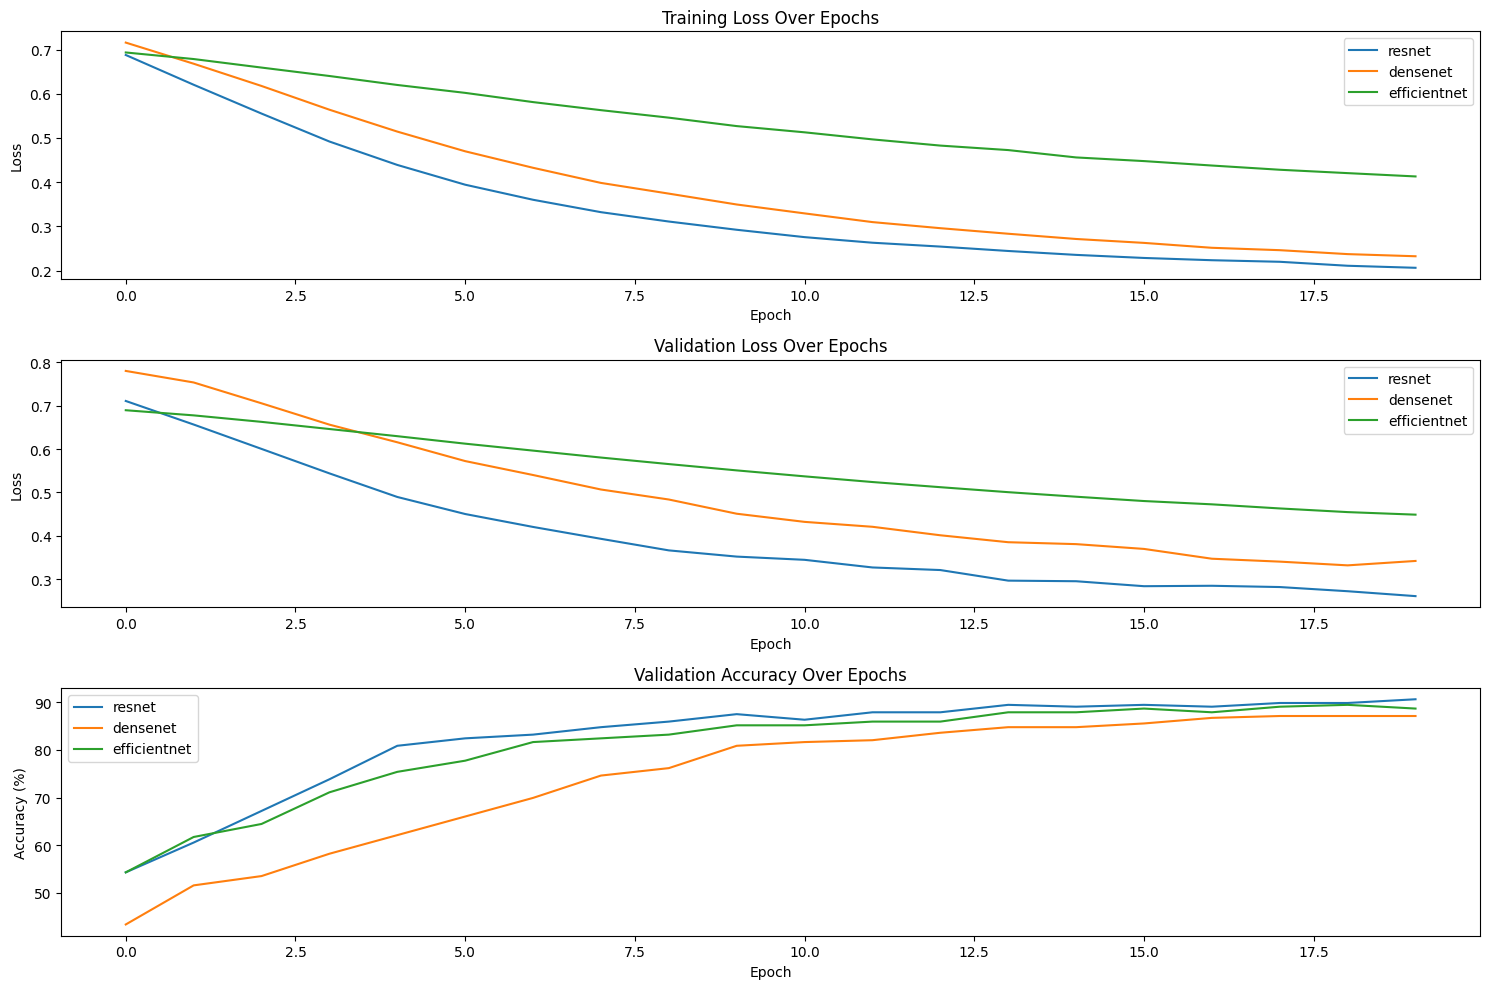

In [ ]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_resnet, label='resnet')
plt.plot(train_losses_densenet, label='densenet')
plt.plot(train_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_resnet, label='resnet')
plt.plot(val_losses_densenet, label='densenet')
plt.plot(val_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_resnet, label='resnet')
plt.plot(val_accuracies_densenet, label='densenet')
plt.plot(val_accuracies_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

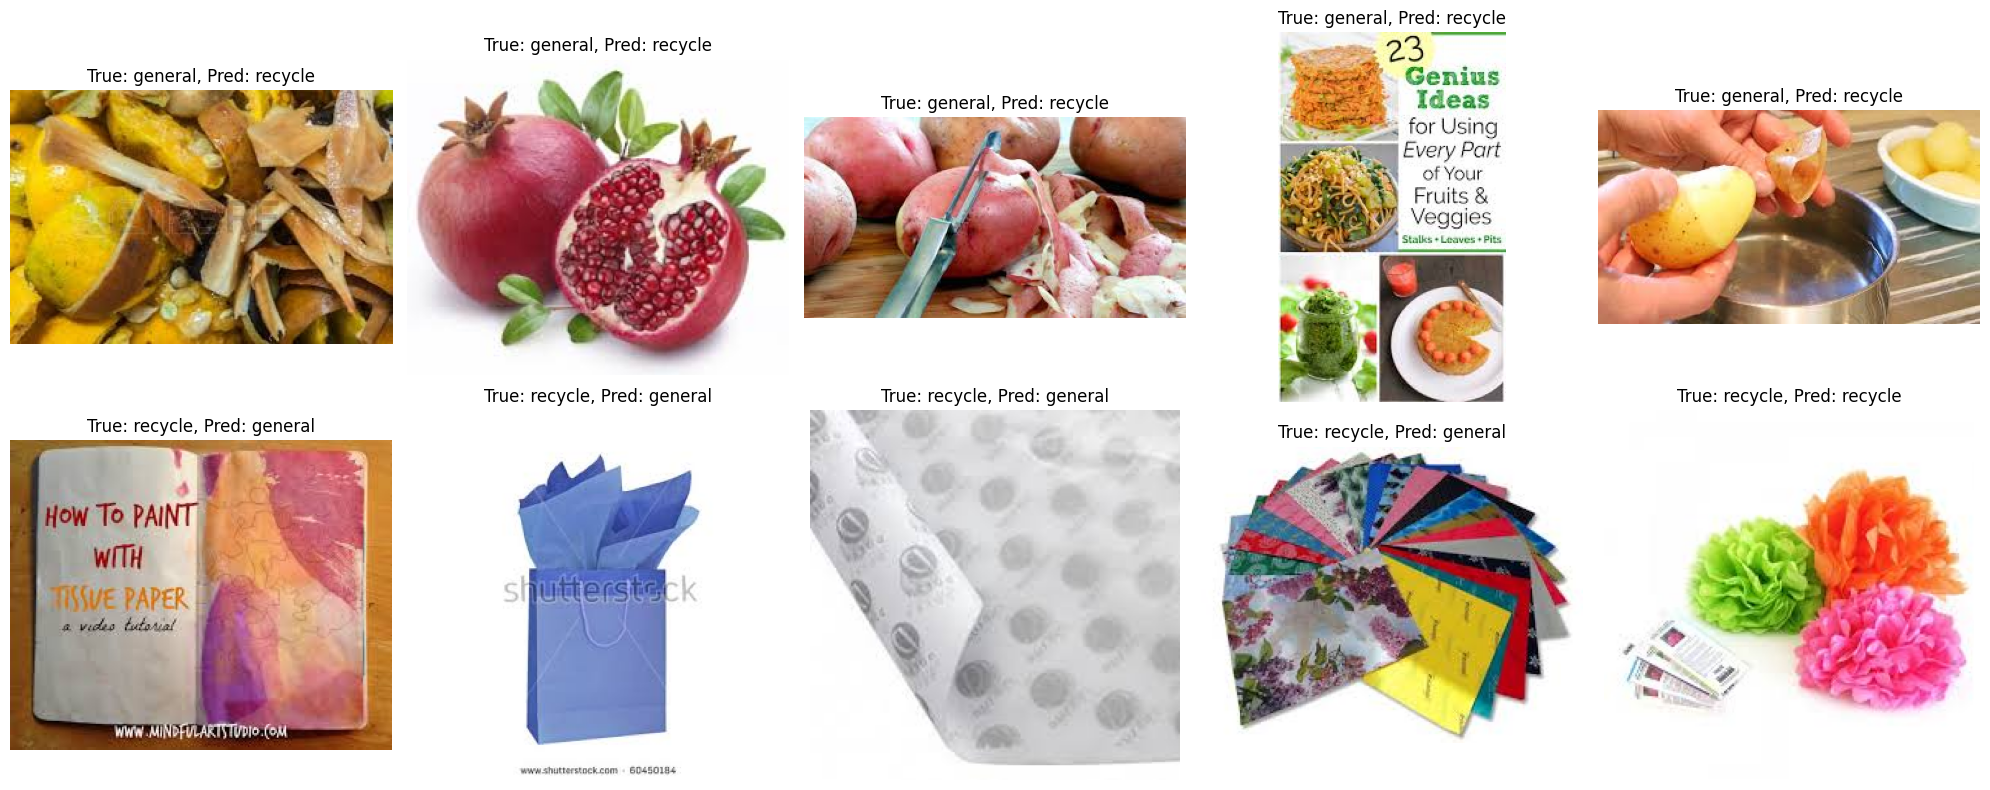

In [ ]:
# 클래스별 폴더 경로
class_folders = {
    'general': '/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/10/test/general',
    'recycle': '/content/drive/Othercomputers/내 Mac/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/10/test/recycle'
}


plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        resnet.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = resnet(image)
            # 시그모이드 함수 적용하여 확률 얻기
            probs = torch.sigmoid(outputs).item()
            prediction = 'general' if probs >= 0.5 else 'recycle'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                probs = torch.sigmoid(outputs).item()
                prediction = 1 if probs >= 0.5 else 0
                all_preds.append(prediction)
                all_labels.append(1 if class_name == 'recycle' else 0)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1


# Evaluate models
resnet_metrics = evaluate_model(resnet, class_folders, pytorch_transforms)
densenet_metrics = evaluate_model(densenet, class_folders, pytorch_transforms)
efficientnet_metrics = evaluate_model(efficientnet, class_folders, pytorch_transforms)

# Print comparison
print("ResNet50 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*resnet_metrics))
print("DenseNet169 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*densenet_metrics))
print("EfficientNetB0 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*efficientnet_metrics))

ResNet50 Metrics: Accuracy: 0.8875, Precision: 0.9480, Recall: 0.8200, F1: 0.8794
DenseNet169 Metrics: Accuracy: 0.8800, Precision: 0.9810, Recall: 0.7750, F1: 0.8659
EfficientNetB0 Metrics: Accuracy: 0.8300, Precision: 0.8976, Recall: 0.7450, F1: 0.8142
